# Movie Analysis Project

## Table of Contents

> #### 1. [Business Understanding](#Business-Understanding)
> #### 2. [Data Understanding](#Data-Understanding)
> #### 3. [Data Preparation](#Data-Preparation)
> #### 4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
> #### 5. [Conclusions](#Conclusions)
> #### 6. [Resources](#Resources)

## 1. <a name ="Business-Understanding"></a> Business Understanding

### Background
My company is looking to get into movie creation using their newly created movie studio. 

### Business Goals
The primary focus of this data science project is to analyze and assess which features of a movie are the most cost efficient. The movie's return on investment will be used to measure cost efficiency in order to make an informed decision regarding what features of movie creation my company should invest in.

### Business Success Criteria
The success of this project will be measured by providing three well-supported recommendations on the most cost efficient movie features (actors, directots, genre, marketing cost, movie rating (G, PG, PG-13, etc.)) to invest in. For this project, the most "cost efficient" features are measured by their return on investment which is defined as 100% times the total revenue divided by the initial investment of the film.

## 2. <a name ="Data-Understanding"></a> Data Understanding

Data on movies is collected by a variety of different sources. For this project, I used data from the following sources:
    
- The Numbers' "movie_budgets" dataset
    - This dataset includes 6 features and 5782 observations. Each entry in the dataset represents a different movie. For each entry, information is included about the movie's release data, production budget, domestic gross box office, and worldwide gross box office.
    
    
- IMDB's film database
    - This database includes 8 tables. Its entity-related diagram (ERD) is shown below. 
    
    - From this database, I used the following tables: movie_basics, persons, and principals
    
    - `movie_basics` includes **6 features** with **146144 observations**. Each entry in this dataset represents a different movie, where `movie_id` is its unique ID (primary key). Additional information is included about each movie such as `original_title`, `runtime_minutes`, and `genres`.
    
    - The `persons` table includes **5 features** with **606648 entries**. Each entry represents a person who took part in a movie, where each person has a unique identifier (`person_id`). This table also includes information about each person such as their `primary_name`, `birth_year`, and `primary_professions` 
    
     - The `principals` table contains **6 features** and **1028186** entries, where each entry represents a person who worked in a movie. This table contains two foreign keys (`movie_id` and `person_id`). Additional information includes the `character` the person played and their role on the film (`category`). 
    ![alt text](Movie_data_ERD.png "Title")
    

In [1]:
# importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sqlite3

In [2]:
#setting up connection to sqlite database

conn = sqlite3.connect('im.db')
cur = conn.cursor()

In [3]:
# reading budgets csv into a pandas dataframe
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


From this output, we see that there are 6 columns, and each column has 0 NaN values. The output also shows that the datatypes for `production_budget`, `domestic_gross`, and `worldwide_gross` are objects. Typically in this stage, it would be helpful to visualize the budget data with a histogram to get a quick sense of the distributions, but since the data types are objects instead of integers or floats, trying to plots histograms will return an error. 

During data preparation these data types will need to be converted to a type that aggregate functions can be performed on. There is also no column with return on investment data, so I will need to calculate that and include it as an additional column with this dataframe. 

In [4]:
# creating a dataframe with a list of all tables in the database

db_tables = pd.read_sql("""

SELECT name
FROM sqlite_master
WHERE type = 'table';

""", conn)

db_tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


This output is important because it provides the names of all the tables available in this database. The tables I will be using in this analysis are `movie_basics`, `persons`, and `principals`. 

In [5]:
# prints the name of each table in the database with the count of rows in each table

table_names = list(db_tables['name'])

tables = {key: None for key in table_names}

for table_name in tables.keys():
    query = f"SELECT COUNT(*) AS num_rows FROM {table_name}"
    tables[table_name] = conn.execute(query).fetchone()[0]
    
tables

{'movie_basics': 146144,
 'directors': 291174,
 'known_for': 1638260,
 'movie_akas': 331703,
 'movie_ratings': 73856,
 'persons': 606648,
 'principals': 1028186,
 'writers': 255873}

The output provides a quick overview of the number of rows in each table in the database. For example, `movie_basics` has 146,144 rows, while `principals` has 1,028,196 entries. This is important to consider when determining the relationship between tables and the type of join that may work best to optimize processing speeds.

In [6]:
# reading the movie_basics table into a pandas dataframe using read_sql and a connection to the database
movie_basics = pd.read_sql("""

SELECT * 
FROM movie_basics

""", conn)

movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


From this output, we see that there are 6 columns and 3 of those columns do not have NaN values. This means that during the Data Preparation phase I will have to inspect the columns with NaN values closely and make a decision about how to proceed with the NaN values.

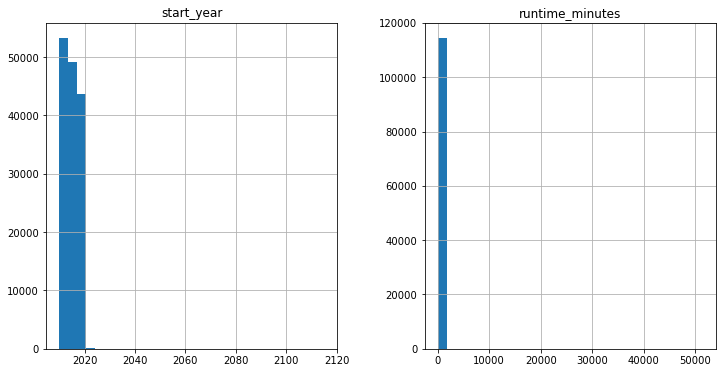

In [7]:
# quickly visualizing the columns of movie_basics that have int or float data types
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 2, 
                       figsize = (12, 6)
                      )
movie_basics.hist(ax = ax, 
                  bins = 30
                 );

This output provides a quick visualization about the shape of any columns stored as integer or float datatype within the `movie_basics` table. The bars for both `start_year` and `runtime_minutes` appear on the left most portion of the graph. This indicates that each feature has outliers that are much greater than the majority of the data. This means during the Data Preparation phase, I will need to inspect the outliers within each of these columns.

In [8]:
# reading the principals table into a pandas dataframe using read_sql and a connection to the database
principals = pd.read_sql("""

SELECT *
FROM principals
""", conn)

principals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB


From this output, we see that there are 6 columns and the `job` and `category` columns have a large number of NaN values. This means that during the Data Preparation phase I will have to inspect these columns closely and make a decision about how to proceed with the NaN values.

In [9]:
# reading the persons table into a pandas dataframe using read_sql and a connection to the database
persons = pd.read_sql("""

SELECT *
FROM persons
""", conn)

persons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB


From this output, we see that there are 5 columns and the `birth_year`, `death_year`, and `primary_profession` columns  have NaN values. This means that during the Data Preparation phase I will have to inspect these columns  closely and make a decision about how to proceed with the NaN values.

## 3. <a name ="Data-Preparation"></a> Data Preparation

In [10]:
# getting a preview of the dataset
budgets.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [11]:
# defining columns to format

budget_cols = ['production_budget', 'domestic_gross', 'worldwide_gross']

In [12]:
# formatting budget columns by removing the $
for col in budget_cols:
     budgets[col] = budgets[col].str.replace('$', '')
        
        
# formatting budget columns by removing commas
for col in budget_cols:
     budgets[col] = budgets[col].str.replace(',', '')

In [13]:
# changing dtype of budget and gross columns to int
for col in budget_cols:
     budgets[col] = budgets[col].astype(float)

In [14]:
# calculating the return on investment for each film and creating a column to hold this information
budgets['roi (%)'] = round(((budgets['worldwide_gross'] 
                            - budgets['production_budget']
                                )
                            / budgets['production_budget']
                                ) 
                            * 100 , 1
                            )

In [15]:
#converting dollar amounts to amounts that are easier to read

for col in budget_cols:
    budgets[col] = round(budgets[col]/1000000, 3)

In [16]:
# renaming columns to include dollar sign

budgets.rename(columns={'production_budget': 'production_budget (millions of $)', 'domestic_gross': 'domestic_gross (millions of $)', 'worldwide_gross' : 'worldwide_gross (millions of $)'}, inplace=True)

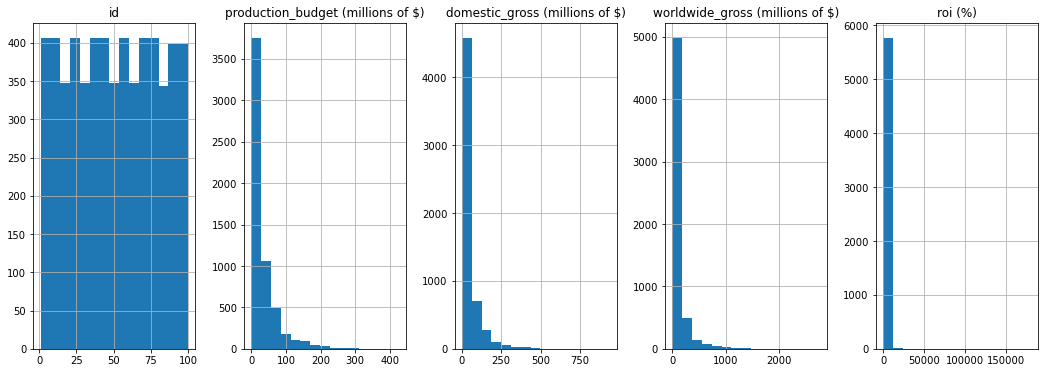

In [17]:
# creating histograms to visualize distributions for each column of budgets
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 5, 
                       figsize = (18, 6)
                      )
budgets.hist(ax = ax,
             bins = 15
            );

Now that the data types of the budget and gross features have been converted to their true data types, histograms can be plotted. The histograms show that the budget and gross columns are skewed right, which means they may contain outliers. This is something to be explored further during the Data Preparation phase. 

In [116]:
budgets[:2]

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,1,"Dec 18, 2009",Avatar,425.0,760.508,2776.345,553.3
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,154.7


In [20]:
# Calculates z-score for each movie's production budget
z = np.abs(stats.zscore(budgets['production_budget (millions of $)']))

# Identify production budget outliers as movies with a z-score greater than 3
outliers = budgets[z > 3]

# Print the production budget outliers
outliers

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,1,"Dec 18, 2009",Avatar,425.0,760.508,2776.345,553.3
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410.6,241.064,1045.664,154.7
2,3,"Jun 7, 2019",Dark Phoenix,350.0,42.762,149.762,-57.2
3,4,"May 1, 2015",Avengers: Age of Ultron,330.6,459.006,1403.014,324.4
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317.0,620.181,1316.722,315.4
...,...,...,...,...,...,...,...
141,42,"Jun 3, 2011",X-Men: First Class,160.0,146.408,355.408,122.1
142,43,"Dec 25, 2008",The Curious Case of Benjamin Button,160.0,127.509,329.632,106.0
143,44,"Jul 14, 2010",The Sorcerer's Apprentice,160.0,63.151,217.986,36.2
144,45,"May 12, 2006",Poseidon,160.0,60.675,181.675,13.5


In [21]:
# creating a new df of budgets with production budget outliers removed
budgets_no_outliers = budgets.drop(outliers.index)

# checking that the correct number of rows were removed
len(budgets) - len(budgets_no_outliers)

146

In [22]:
budgets_no_outliers['id'].value_counts()

74    57
54    57
68    57
72    57
76    57
      ..
30    56
34    56
38    56
42    56
4     56
Name: id, Length: 100, dtype: int64

In [23]:
# inspecting all entries with id of '4'
budgets_no_outliers[budgets_no_outliers['id'] == 4].head(15)

,id,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
203,4,"Jul 15, 2016",Ghostbusters,144.0,128.351,229.009,59.0
303,4,"May 19, 1999",Star Wars Ep. I: The Phantom Menace,115.0,474.545,1027.045,793.1
403,4,"Dec 14, 2018",Mortal Engines,100.0,15.951,85.287,-14.7
503,4,"Sep 29, 2006",Open Season,85.0,85.105,191.932,125.8
603,4,"Dec 25, 1997",The Postman,80.0,17.651,20.841,-73.9
703,4,"Aug 8, 2003",S.W.A.T.,70.0,116.878,207.155,195.9
803,4,"Sep 14, 2012",Resident Evil: Retribution,65.0,42.346,240.648,270.2
903,4,"Jan 11, 2013",Gangster Squad,60.0,46.001,104.101,73.5
1003,4,"Apr 10, 1998",City of Angels,55.0,78.751,198.751,261.4
1103,4,"Aug 9, 2013",Disney Planes,50.0,90.283,238.060,376.1


In [117]:
# dropping id column from dataset
budgets_no_outliers.drop(['id'], axis=1, inplace=True)
budgets_no_outliers.head(3)

KeyError: "['id'] not found in axis"

In [25]:
# checking for duplicate movie entries
budgets_no_outliers.movie.value_counts()

Home                      3
Halloween                 3
RoboCop                   2
Death at a Funeral        2
Left Behind               2
                         ..
Kickboxer                 1
The To Do List            1
For Your Consideration    1
Pride and Glory           1
Jackie                    1
Name: movie, Length: 5562, dtype: int64

In [26]:
# checking for any movie titles with more than one entry to see if it is a duplicate entry or a remake

multiple_values = budgets_no_outliers.movie.value_counts()
budgets_no_outliers[budgets_no_outliers.movie.isin(multiple_values.index[multiple_values.gt(1)])]

,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
203,"Jul 15, 2016",Ghostbusters,144.000,128.351,229.009,59.0
243,"Mar 27, 2015",Home,130.000,177.398,385.998,196.9
267,"Aug 8, 2014",Teenage Mutant Ninja Turtles,125.000,191.205,485.005,288.0
271,"Apr 1, 2010",Clash of the Titans,125.000,163.215,493.215,294.6
278,"Aug 3, 2012",Total Recall,125.000,58.878,211.856,69.5
...,...,...,...,...,...,...
5668,"Nov 16, 1942",Cat People,0.134,4.000,8.000,5870.1
5676,"Oct 1, 1968",Night of the Living Dead,0.114,12.087,30.087,26292.2
5677,"Feb 8, 1915",The Birth of a Nation,0.110,10.000,11.000,9900.0
5699,"Aug 30, 1972",The Last House on the Left,0.087,3.100,3.100,3463.2


In [120]:
# getting summary statistics for budgets df columns
round(budgets_no_outliers.describe(), 1)

,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
count,5636.0,5636.0,5636.0,5636.0
mean,27.2,36.6,75.9,383.6
std,31.0,54.6,129.8,2990.8
min,0.0,0.0,0.0,-100.0
25%,5.0,1.2,3.7,-53.5
50%,16.0,16.0,26.1,66.4
75%,38.0,48.6,89.2,269.9
max,156.0,474.5,1341.7,179900.0


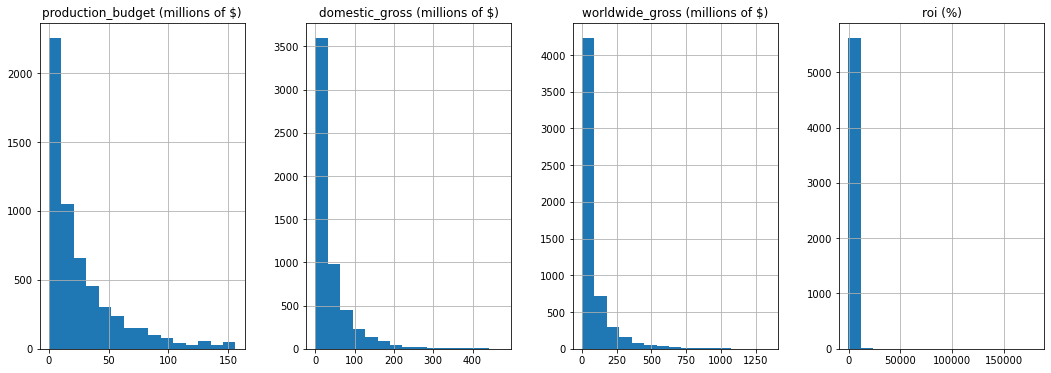

In [28]:
# creating histograms to visualize distributions for each column of budgets_no_outliers
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 4, 
                       figsize = (18, 6)
                      )

budgets_no_outliers.hist(ax = ax, 
                         bins = 15
                        );

With the budgest data set cleaned and processed the histograms display more helpful information. The histograms still appear right skewed even though production budget outliers were removed, but this is still an improvement from earlier. Now the tails for each feature are more prominent, and we can be more confident that analysis of the budgets data will lead reliable results. 

In [29]:
movie_basics.head(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [118]:
# returning preview of the rows of movie_basics for movies with outlier runtimes
movie_basics[movie_basics['runtime_minutes'] > (movie_basics['runtime_minutes'].mean()+ 3*movie_basics['runtime_minutes'].std())].head()

,movie_id,primary_title,start_year,runtime_minutes,genres,genres_list
6311,tt1277455,A Time to Stir,2018,1320.0,Documentary,[Documentary]
12974,tt1674154,City of Eternal Spring,2010,3450.0,"Documentary,Drama,News","[Documentary, Drama, News]"
15381,tt1735956,Deregulation,2012,4200.0,"Comedy,Drama","[Comedy, Drama]"
15796,tt1745901,How Does David Lynch Do It?,2010,1800.0,Mystery,[Mystery]
18210,tt1806770,American Fencer,2010,761.0,"Biography,Documentary,Drama","[Biography, Documentary, Drama]"


In [31]:
# returning the rows of movie_basics where the movie start year is in the future
movie_basics[movie_basics['start_year'] > 2024]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
2949,tt10300398,Untitled Star Wars Film,Untitled Star Wars Film,2026,NaN,Fantasy
52213,tt3095356,Avatar 4,Avatar 4,2025,NaN,"Action,Adventure,Fantasy"
89506,tt5174640,100 Years,100 Years,2115,NaN,Drama
96592,tt5637536,Avatar 5,Avatar 5,2027,NaN,"Action,Adventure,Fantasy"


In [32]:
# removing any rows with movies whose start year is past 2024
movie_basics = movie_basics[movie_basics['start_year'] <= 2024]

# checks to ensure that rows were removed
movie_basics[movie_basics['start_year'] > 2024]

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres


In [33]:
# comparing movies whose primary title does not match its original title

movie_basics[movie_basics['primary_title'] != movie_basics['original_title']][['primary_title', 'original_title']]

,primary_title,original_title
1,One Day Before the Rainy Season,Ashad Ka Ek Din
4,The Wandering Soap Opera,La Telenovela Errante
11,So Much for Justice!,Oda az igazság
13,Children of the Green Dragon,A zöld sárkány gyermekei
15,The Tragedy of Man,Az ember tragédiája
...,...,...
146026,Journey of the Sky Goddess,Kibaiyanse! Watashi
146028,Lupin the Third: Fujiko Mine's Lie,Lupin the IIIrd: Mine Fujiko no Uso
146037,Big Three Dragons,Da San Yuan
146121,A Cherry Tale,Kirsebæreventyret


In [34]:
# getting count of all movies whose primary title doesn't match its original title 
movie_basics[movie_basics['primary_title'] != movie_basics['original_title']]['original_title'].value_counts()

La traversée                   3
Hatsukoi                       2
Dom                            2
Corps étranger                 2
Missed Connections             2
                              ..
Shuang cheng ji zhong ji       1
Kyô no Kira kun                1
Hathihi swrati wa ana mayet    1
Aux yeux de tous               1
Chun-mong                      1
Name: original_title, Length: 14452, dtype: int64

In [35]:
# removing original title column
movie_basics.drop('original_title',
                  axis=1,
                  inplace=True
                 )

In [36]:
# get a count for the number of each genre

movie_basics['genres'].str.split(',').explode().value_counts()

Documentary    51640
Drama          49882
Comedy         25312
Thriller       11883
Horror         10805
Action         10333
Romance         9372
Biography       8722
Crime           6753
Adventure       6463
Family          6227
History         6225
Mystery         4659
Music           4314
Fantasy         3513
Sci-Fi          3365
Animation       2799
Sport           2234
News            1551
Musical         1430
War             1405
Western          467
Reality-TV        98
Talk-Show         50
Adult             25
Short             11
Game-Show          4
Name: genres, dtype: int64

In [37]:
# formatting genres column to create a list containing each genre for the film
movie_basics["genres_list"] = movie_basics["genres"].str.split(",")

In [38]:
# display number of nan values for each feature
movie_basics.isna().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    31735
genres              5408
genres_list         5408
dtype: int64

In [39]:
# return the number of rows with nans in both genre and runtime
len(movie_basics.loc[movie_basics['genres'].isnull() 
                     & movie_basics['runtime_minutes'].isnull()
                    ]
   )

3236

In [40]:
# removing rows from movie_basics with null genre and runtime
movie_basics_clean = movie_basics.drop(
                                        movie_basics.loc[movie_basics['genres'].isnull() 
                                         & movie_basics['runtime_minutes'].isnull()].index
                                      )
movie_basics_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142904 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         142904 non-null  object 
 1   primary_title    142904 non-null  object 
 2   start_year       142904 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140732 non-null  object 
 5   genres_list      140732 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.6+ MB


In [41]:
# confirming that correct number of rows were filtered out
len(movie_basics) - len(movie_basics_clean)

3236

In [42]:
movie_basics_clean.isna().sum()

movie_id               0
primary_title          0
start_year             0
runtime_minutes    28499
genres              2172
genres_list         2172
dtype: int64

In [43]:
principals.head()

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


In [44]:
principals.person_id.value_counts()

nm1930572    378
nm0000636    160
nm0000616    148
nm0103977    126
nm4394575    103
            ... 
nm8787308      1
nm9125196      1
nm3773200      1
nm0598955      1
nm1000298      1
Name: person_id, Length: 604546, dtype: int64

In [45]:
principals[principals['person_id'] == 'nm4394575']

,movie_id,ordering,person_id,category,job,characters
209253,tt2414424,9,nm4394575,editor,None,None
284938,tt2418914,7,nm4394575,editor,None,None
291705,tt3445098,9,nm4394575,editor,None,None
341007,tt2419230,8,nm4394575,editor,None,None
344804,tt2410964,8,nm4394575,editor,None,None
...,...,...,...,...,...,...
983231,tt9525226,7,nm4394575,editor,None,None
984125,tt6370780,8,nm4394575,editor,None,None
984135,tt6374832,8,nm4394575,editor,None,None
1012364,tt7843050,6,nm4394575,editor,None,None


In [46]:
principals['category'].value_counts()

actor                  256718
director               146393
actress                146208
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65424
editor                  55512
production_designer      9373
archive_footage          3307
archive_sound              16
Name: category, dtype: int64

In [47]:
principals['job'].value_counts()

producer                                108168
screenplay                                8172
director of photography                   6517
writer                                    6479
co-director                               5796
                                         ...  
play L'Eveil du chameau                      1
novel "Ne nous fâchons pas, Imogène!         1
comic "Kimi wa petto                         1
based on the book "Swim Rat Swim" by         1
french translator                            1
Name: job, Length: 2965, dtype: int64

In [48]:
principals['characters'].value_counts()

["Himself"]                                                 43584
["Herself"]                                                 16127
["Narrator"]                                                 2218
["Alex"]                                                      656
["David"]                                                     620
                                                            ...  
["Bobby Belmundo"]                                              1
["Agent Mike Fox"]                                              1
["Prosecuting attorney"]                                        1
["Woman","Dead Body with Walkie-Talkie","Woman in Snow"]        1
["The Soulmate"]                                                1
Name: characters, Length: 174762, dtype: int64

In [49]:
# Dropping job and character columns 

principals.drop(['job', 'characters', 'ordering'], axis=1, inplace=True)

In [50]:
persons.head()

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


In [51]:
# get a count for the number of each profession
persons['primary_profession'].str.split(',').explode().value_counts()

actor                        177838
producer                     150214
writer                       141504
director                     129808
actress                       95066
cinematographer               61984
editor                        55234
composer                      48823
camera_department             39466
miscellaneous                 38661
soundtrack                    20748
music_department              18568
assistant_director            15916
sound_department              15280
editorial_department          14565
production_manager             9768
art_department                 8913
production_designer            7592
visual_effects                 6188
art_director                   4623
stunts                         4309
casting_department             2802
executive                      2657
make_up_department             2613
animation_department           2459
casting_director               2397
location_management            2253
costume_department          

In [52]:
# dropping birth_year, death_year, and primary_profression from persons
persons.drop(['birth_year', 'death_year', 'primary_profession'], axis=1, inplace=True)

In [53]:
# function that provides the .info() for the remaining three data frames I am working with
data = [movie_basics_clean, principals, persons]
def get_info(dataframes):
    for df in dataframes:
        print("--------")
        print()
        print(df.info())

In [54]:
get_info(data)

--------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142904 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         142904 non-null  object 
 1   primary_title    142904 non-null  object 
 2   start_year       142904 non-null  int64  
 3   runtime_minutes  114405 non-null  float64
 4   genres           140732 non-null  object 
 5   genres_list      140732 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 7.6+ MB
None
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   movie_id   1028186 non-null  object
 1   person_id  1028186 non-null  object
 2   category   1028186 non-null  object
dtypes: object(3)
memory usage: 23.5+ MB
None
--------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6066

In [55]:
# joining principals and persons dfs

film_people = pd.merge(persons,
                       principals,
                       how = 'inner',
                       on = 'person_id'
                      )

film_people.head()

,person_id,primary_name,movie_id,category
0,nm0061671,Mary Ellen Bauder,tt2398241,producer
1,nm0061865,Joseph Bauer,tt0433397,composer
2,nm0061865,Joseph Bauer,tt1681372,composer
3,nm0061865,Joseph Bauer,tt2387710,composer
4,nm0061865,Joseph Bauer,tt2281215,composer


In [56]:
film_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027912 entries, 0 to 1027911
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   person_id     1027912 non-null  object
 1   primary_name  1027912 non-null  object
 2   movie_id      1027912 non-null  object
 3   category      1027912 non-null  object
dtypes: object(4)
memory usage: 39.2+ MB


In [57]:
# get counts of the different categories of film professions
film_people.category.value_counts()

actor                  256561
director               146393
actress                146124
producer               113724
cinematographer         80091
composer                77063
writer                  74357
self                    65392
editor                  55512
production_designer      9373
archive_footage          3306
archive_sound              16
Name: category, dtype: int64

In [58]:
film_people.person_id.value_counts()

nm1930572    378
nm0000636    160
nm0000616    148
nm0103977    126
nm4394575    103
            ... 
nm8684819      1
nm0830597      1
nm4591968      1
nm3313536      1
nm7618909      1
Name: person_id, Length: 604290, dtype: int64

In [59]:
film_people[film_people['person_id'] == 'nm4394575']

,person_id,primary_name,movie_id,category
415221,nm4394575,Sen Arima,tt2414424,editor
415222,nm4394575,Sen Arima,tt2418914,editor
415223,nm4394575,Sen Arima,tt3445098,editor
415224,nm4394575,Sen Arima,tt2419230,editor
415225,nm4394575,Sen Arima,tt2410964,editor
...,...,...,...,...
415319,nm4394575,Sen Arima,tt9525226,editor
415320,nm4394575,Sen Arima,tt6370780,editor
415321,nm4394575,Sen Arima,tt6374832,editor
415322,nm4394575,Sen Arima,tt7843050,editor


In [60]:
film_people.value_counts()

person_id  primary_name     movie_id   category
nm3296031  Brendan Maclean  tt2815358  actor       2
nm2442121  Ivy Yi-Han Chen  tt8942260  actress     2
nm4454963  Mike Kai Sui     tt6450032  actor       2
nm3206691  Hasan Majuni     tt2258513  actor       2
nm1289422  Barbara Bacci    tt3153648  actress     2
                                                  ..
nm4885985  Rémi Goulet      tt7610830  actor       1
                            tt4027334  actor       1
                            tt2224307  actor       1
nm4885974  Mónica Portillo  tt6207386  actress     1
nm0000002  Lauren Bacall    tt0858500  actress     1
Length: 1027877, dtype: int64

In [61]:
# removes duplicate rows that share the same movie_id and person_id

film_people_duplicates = film_people.duplicated(keep = False)
film_people[film_people_duplicates].value_counts()

person_id  primary_name            movie_id   category
nm9161308  Sameer Deshpande        tt5489544  actor       2
nm1289422  Barbara Bacci           tt3153648  actress     2
nm3296031  Brendan Maclean         tt2815358  actor       2
nm3206691  Hasan Majuni            tt2258513  actor       2
nm3187984  Abdellatif Chaouqi      tt3592504  actor       2
nm2442121  Ivy Yi-Han Chen         tt8942260  actress     2
nm2335900  Justin Malone           tt1995481  actor       2
nm1794850  David Chalmers          tt2073120  actor       2
nm1141719  Nobuyuki Kase           tt5098626  actor       2
nm3548929  Liuyuan Ding            tt5338100  actress     2
nm0857847  Thich Nhát Hanh         tt5268106  actor       2
nm0849468  Masashi Taniguchi       tt8108180  actor       2
nm0605583  Robert Morin            tt6664852  actor       2
nm0406809  Kunihiko Ida            tt5495582  actor       2
nm0244327  Dorra Zarrouk           tt6549064  actress     2
nm0172826  Luigi Cozzi             tt4537170 

In [62]:
film_people_no_dups = film_people.drop_duplicates()
film_people_no_dups.value_counts()

person_id  primary_name               movie_id    category
nm9993680  Christopher-Lawson Palmer  tt10427366  actor       1
nm1822501  Reece Rios                 tt1591509   actor       1
nm1822600  Anastas Tanovski           tt7610008   actor       1
nm1822582  Claude Stark               tt6046566   actor       1
nm1822570  Esham                      tt2006716   self        1
                                                             ..
nm4886005  Abi Alberto                tt2224159   director    1
nm4885998  Mott Green                 tt2224377   self        1
nm4885985  Rémi Goulet                tt7610830   actor       1
                                      tt4027334   actor       1
nm0000002  Lauren Bacall              tt0858500   actress     1
Length: 1027877, dtype: int64

In [63]:
film_people_no_dups.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1027877 entries, 0 to 1027911
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   person_id     1027877 non-null  object
 1   primary_name  1027877 non-null  object
 2   movie_id      1027877 non-null  object
 3   category      1027877 non-null  object
dtypes: object(4)
memory usage: 39.2+ MB


In [64]:
# inner joining film_people_no_dups and movie_basics_clean using movie_id as the key

pd.merge(film_people_no_dups,
         movie_basics_clean,
         how = 'inner',
         on = 'movie_id'
        )

,person_id,primary_name,movie_id,category,primary_title,start_year,runtime_minutes,genres,genres_list
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
1,nm0038432,Kelly Asbury,tt2398241,director,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
2,nm0449549,Jordan Kerner,tt2398241,producer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
3,nm0962596,Pamela Ribon,tt2398241,writer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
4,nm0678963,Peyo,tt2398241,writer,Smurfs: The Lost Village,2017,90.0,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
...,...,...,...,...,...,...,...,...,...
1017234,nm9529323,Klaus Erik Okstad,tt7826456,director,Det Afghanske Marerittet,2011,54.0,Documentary,[Documentary]
1017235,nm9734471,Reza Aghaei,tt8207434,director,Glasses,2017,75.0,"Drama,Family","[Drama, Family]"
1017236,nm9743728,Efrain Sosa,tt8226498,director,Finding the Night of the Dead,2019,62.0,Documentary,[Documentary]
1017237,nm9909687,Bastien Larue,tt8561352,director,Les officiants,2016,52.0,Documentary,[Documentary]


In [65]:
# joining film_people_no_dups and movie_basics_clean

film_people_with_movies = pd.merge(film_people_no_dups,
                                   movie_basics_clean,
                                   how = 'inner',
                                   on = 'movie_id'
                                  )

In [66]:
# Dropping job and character columns 

film_people_with_movies.drop('runtime_minutes',
                             axis=1,
                             inplace=True
                            )

In [67]:
film_people_with_movies.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list
0,nm0061671,Mary Ellen Bauder,tt2398241,producer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
1,nm0038432,Kelly Asbury,tt2398241,director,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
2,nm0449549,Jordan Kerner,tt2398241,producer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
3,nm0962596,Pamela Ribon,tt2398241,writer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"
4,nm0678963,Peyo,tt2398241,writer,Smurfs: The Lost Village,2017,"Adventure,Animation,Comedy","[Adventure, Animation, Comedy]"


In [68]:
film_people_with_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017239 entries, 0 to 1017238
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   person_id      1017239 non-null  object
 1   primary_name   1017239 non-null  object
 2   movie_id       1017239 non-null  object
 3   category       1017239 non-null  object
 4   primary_title  1017239 non-null  object
 5   start_year     1017239 non-null  int64 
 6   genres         1006126 non-null  object
 7   genres_list    1006126 non-null  object
dtypes: int64(1), object(7)
memory usage: 69.8+ MB


In [69]:
# removing any person with a frequency less than three 

#gets a count of the frequency of each person's name in the df
film_people_value_counts = film_people_with_movies.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_people = film_people_value_counts[film_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
film_people_mult_movies = film_people_with_movies[~film_people_with_movies['primary_name'].isin(remove_people)]

In [70]:
film_people_mult_movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 448252 entries, 1 to 1017213
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   person_id      448252 non-null  object
 1   primary_name   448252 non-null  object
 2   movie_id       448252 non-null  object
 3   category       448252 non-null  object
 4   primary_title  448252 non-null  object
 5   start_year     448252 non-null  int64 
 6   genres         443892 non-null  object
 7   genres_list    443892 non-null  object
dtypes: int64(1), object(7)
memory usage: 30.8+ MB


In [71]:
# list of movies in the top 25% of roi
top_25_percent_roi = list(budgets_no_outliers[budgets_no_outliers['roi (%)'] 
                                              > budgets_no_outliers['roi (%)'].quantile(.75)].sort_values(
                                                by = ['roi (%)'], ascending = False)['movie']
                         )

In [72]:
# filtering movie_basics_clean to only include movies in the top 25% of roi

top_roi_movie_basics = movie_basics_clean[movie_basics_clean['primary_title'].isin(top_25_percent_roi)]
top_roi_movie_basics.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,genres_list
33,tt0293429,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy","[Action, Adventure, Fantasy]"
40,tt0326592,The Overnight,2010,88.0,None,None
97,tt0431021,The Possession,2012,92.0,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]"
115,tt0443272,Lincoln,2012,150.0,"Biography,Drama,History","[Biography, Drama, History]"
125,tt0448115,Shazam!,2019,132.0,"Action,Adventure,Comedy","[Action, Adventure, Comedy]"


In [73]:
top_roi_movie_basics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798 entries, 33 to 145296
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         798 non-null    object 
 1   primary_title    798 non-null    object 
 2   start_year       798 non-null    int64  
 3   runtime_minutes  720 non-null    float64
 4   genres           792 non-null    object 
 5   genres_list      792 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 43.6+ KB


In [74]:
# creates df containing the people involved in the movies in the top 25% of roi
top_roi_film_people = film_people_mult_movies[film_people_mult_movies['primary_title'].isin(top_25_percent_roi)]
top_roi_film_people.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list
833,nm0192984,Paul Currie,tt2119532,producer,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
834,nm0941777,Sam Worthington,tt2119532,actor,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
835,nm0460795,Andrew Knight,tt2119532,writer,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
837,nm0202704,Bruce Davey,tt2119532,producer,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"
838,nm0000154,Mel Gibson,tt2119532,director,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]"


In [75]:
# removing any person with a frequency less than three 

#gets a count of the frequency of each person's name in the df
top_people_value_counts = top_roi_film_people.primary_name.value_counts() 

# selects the names that appear less than 3 times
remove_ppl = top_people_value_counts[top_people_value_counts < 3].index

# filters out rows that have a primary_name that is in remove_people
top_roi_people = top_roi_film_people[~top_roi_film_people['primary_name'].isin(remove_ppl)]

In [76]:
top_roi_people.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 978 entries, 841 to 733268
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   person_id      978 non-null    object
 1   primary_name   978 non-null    object
 2   movie_id       978 non-null    object
 3   category       978 non-null    object
 4   primary_title  978 non-null    object
 5   start_year     978 non-null    int64 
 6   genres         978 non-null    object
 7   genres_list    978 non-null    object
dtypes: int64(1), object(7)
memory usage: 68.8+ KB


In [77]:
# joining top_roi_film_people and budgets

top_people_budgets = pd.merge(top_roi_people,
                              budgets_no_outliers, 
                              how = 'inner',
                              left_on = 'primary_title',
                              right_on = 'movie'
                             )
top_people_budgets.head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
0,nm1954240,Teresa Palmer,tt2119532,actress,Hacksaw Ridge,2016,"Biography,Drama,History","[Biography, Drama, History]","Nov 4, 2016",Hacksaw Ridge,40.0,67.210,168.905,322.3
1,nm0001752,Steven Soderbergh,tt2268016,cinematographer,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.013,123.661,752.8
2,nm1475594,Channing Tatum,tt2268016,actor,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.013,123.661,752.8
3,nm1749221,Nina Jacobson,tt1650043,producer,Diary of a Wimpy Kid: Rodrick Rules,2011,"Comedy,Family","[Comedy, Family]","Mar 25, 2011",Diary of a Wimpy Kid: Rodrick Rules,18.0,52.699,73.695,309.4
4,nm0331516,Ryan Gosling,tt1120985,actor,Blue Valentine,2010,"Drama,Romance","[Drama, Romance]","Dec 29, 2010",Blue Valentine,1.0,9.738,16.566,1556.6


In [78]:
top_people_budgets.person_id.value_counts()

nm0089658    34
nm0000881    10
nm0286320     8
nm0079677     8
nm0366389     8
             ..
nm1557329     3
nm1085924     3
nm0045209     3
nm0425053     2
nm2053216     1
Name: person_id, Length: 248, dtype: int64

In [79]:
top_people_budgets.category.value_counts()

actor              299
producer           268
actress            202
writer             112
director            86
composer            49
cinematographer     11
self                 3
editor               2
Name: category, dtype: int64

In [80]:
top_people_budgets['category'] = top_people_budgets.category.replace('actress','actor')

In [81]:
top_people_budgets['category'] = top_people_budgets.category.str.title()

In [82]:
top_people_budgets.category.value_counts()

Actor              501
Producer           268
Writer             112
Director            86
Composer            49
Cinematographer     11
Self                 3
Editor               2
Name: category, dtype: int64

In [83]:
top_people_budgets[top_people_budgets['category'] == 'Cinematographer'].head()

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
1,nm0001752,Steven Soderbergh,tt2268016,Cinematographer,Magic Mike XXL,2015,"Comedy,Drama,Music","[Comedy, Drama, Music]","Jul 1, 2015",Magic Mike XXL,14.5,66.013,123.661,752.8
526,nm1227638,Mike Gioulakis,tt4972582,Cinematographer,Split,2016,"Horror,Thriller","[Horror, Thriller]","Jan 20, 2017",Split,5.0,138.142,278.965,5479.3
529,nm0002947,Toby Oliver,tt5052448,Cinematographer,Get Out,2017,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]","Feb 24, 2017",Get Out,5.0,176.041,255.368,5007.4
533,nm0002947,Toby Oliver,tt5308322,Cinematographer,Happy Death Day,2017,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]","Oct 13, 2017",Happy Death Day,5.0,55.684,125.010,2400.2
538,nm1227638,Mike Gioulakis,tt6857112,Cinematographer,Us,2019,"Horror,Mystery,Thriller","[Horror, Mystery, Thriller]","Mar 22, 2019",Us,20.0,175.007,254.210,1171.1


In [84]:
categories_to_drop = top_people_budgets.category.value_counts().sort_values(ascending = True).head(3).index
categories_to_drop

Index(['Editor', 'Self', 'Cinematographer'], dtype='object')

In [85]:
top_people_budgets = top_people_budgets[~top_people_budgets['category'].isin(categories_to_drop)]

In [86]:
top_people_budgets.primary_name.value_counts()

Jason Blum           34
Michael Bay          10
Andrew Form           8
Kristen Wiig          8
Eric Fellner          8
                     ..
Danny Elfman          3
Ryan Coogler          3
Bear McCreary         3
Steven Soderbergh     2
Gregory Plotkin       1
Name: primary_name, Length: 244, dtype: int64

In [87]:
top_people_budgets[top_people_budgets['person_id'] == 'nm1512937']

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)


In [88]:
top_people_budgets[top_people_budgets['primary_name'] == 'Paul Walker']

,person_id,primary_name,movie_id,category,primary_title,start_year,genres,genres_list,release_date,movie,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)


In [89]:
top_people_budgets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1031
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_id                          1016 non-null   object 
 1   primary_name                       1016 non-null   object 
 2   movie_id                           1016 non-null   object 
 3   category                           1016 non-null   object 
 4   primary_title                      1016 non-null   object 
 5   start_year                         1016 non-null   int64  
 6   genres                             1016 non-null   object 
 7   genres_list                        1016 non-null   object 
 8   release_date                       1016 non-null   object 
 9   movie                              1016 non-null   object 
 10  production_budget (millions of $)  1016 non-null   float64
 11  domestic_gross (millions of $)     1016 non-null   float

In [90]:
dfs_for_analysis = [top_people_budgets, top_roi_movie_basics, budgets_no_outliers]
get_info(dfs_for_analysis)

--------

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1031
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   person_id                          1016 non-null   object 
 1   primary_name                       1016 non-null   object 
 2   movie_id                           1016 non-null   object 
 3   category                           1016 non-null   object 
 4   primary_title                      1016 non-null   object 
 5   start_year                         1016 non-null   int64  
 6   genres                             1016 non-null   object 
 7   genres_list                        1016 non-null   object 
 8   release_date                       1016 non-null   object 
 9   movie                              1016 non-null   object 
 10  production_budget (millions of $)  1016 non-null   float64
 11  domestic_gross (millions of $)     1016 non-nu

The output from the get_info() function shows that in each table, each column's python data type matches its true data type. In the `top_roi_movie_basics` DataFrame, the following three columns still have a few NaN values: `runtime_minutes`, `genres`, `genres_list`. Since this DataFrame, only has 785 entries, simply removing these rows could result in significant data loss. I leave these NaN values because I still have enough data in each of those rows for meaningful analysis, and I do not want to lose any important data by removing these rows.

## 4. <a name ="Exploratory-Data-Analysis"></a> Exploratory Data Analysis

The following are findings from this analysis:
- Of the 5,636 movies with functional budget data, **62% achieved a positive ROI**. 


- The typical movie had an estimated **16 million dollar production budget**, generated an estimated **26 million dollars in worldwide gross revenue**, and produced an estimated **66% return on investment**.


- **Dramas** and **comedies** were the two **most common genres** for the movies in the top 25% of ROI.


- The middle 50% of the movies with the highest ROI had **runtimes between 87 and 113 minutes**.


- The three film **professions that generate the highest ROI** are: **producers**, **writers**, & **directors**.

 - The 5 highest grossing ***producers*** are: Simon Kinberg, Dana Brunetti, Michael De Luca, Wyck Godfrey, Peter Chernin
  - The 5 highest grossing ***writers*** are: E.L. James, Anthony McCarten, Linda Woolverton, Eric Heisserer, Robert Mark Kamen
 - The 5 highest grossing ***directors*** are: David O. Russell, Steven Spielberg, Damien Chazelle, Lasse Hallström, Jon M. Chu

In [121]:
# getting summary statistics for the int cols of the budgets table
round(budgets_no_outliers.describe(), 1)

,production_budget (millions of $),domestic_gross (millions of $),worldwide_gross (millions of $),roi (%)
count,5636.0,5636.0,5636.0,5636.0
mean,27.2,36.6,75.9,383.6
std,31.0,54.6,129.8,2990.8
min,0.0,0.0,0.0,-100.0
25%,5.0,1.2,3.7,-53.5
50%,16.0,16.0,26.1,66.4
75%,38.0,48.6,89.2,269.9
max,156.0,474.5,1341.7,179900.0


In [92]:
len(budgets_no_outliers)

5636

In [127]:
# total percentage of films that had a positive ROI
round(len(budgets_no_outliers[budgets_no_outliers['roi (%)'] > 0])/ len(budgets_no_outliers) * 100, 2)

62.38

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


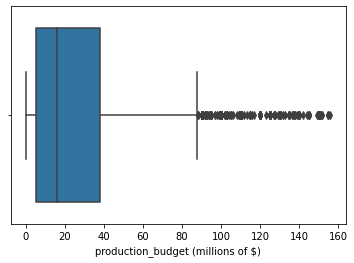

In [95]:
sns.boxplot(budgets_no_outliers['production_budget (millions of $)']);

The boxplot above shows...

In [96]:
# getting the top genres for the movies in the top 25% roi

top_genres_count = top_roi_movie_basics['genres'].str.split(",").explode().value_counts()
top_genres = list(top_genres_count.index)
top_2_genres = top_genres[:2]

In [97]:
# calculates percentage of the two most common genres
top_genres_count_normalized = top_roi_movie_basics['genres'].str.split(",").explode().value_counts(normalize = True)
round(top_genres_count_normalized[:2].sum()* 100, 1)

34.2

This output represents the percentage of all movies that were classified as either Dramas and/or Comedies.

In [98]:
# setting colors for bars of barplot
top_genres_bar_colors = ['darkorange' if x in top_2_genres else 'lightgrey' for x in top_genres]

# setting colors for ticks of barplot
top_genres_tick_colors = ['black' if x in top_2_genres else 'grey' for x in top_genres]

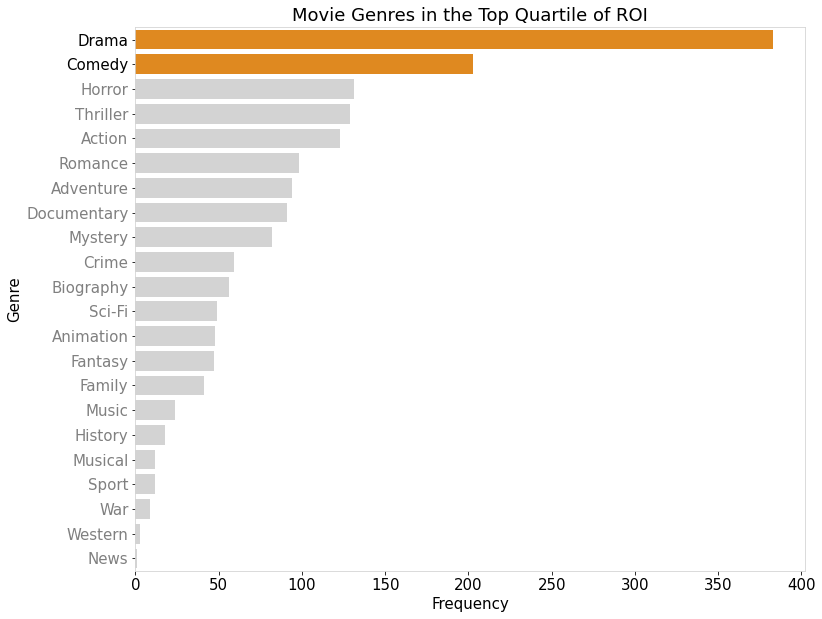

In [99]:
# horizontal bar plot showing the counts of genres for highest roi movies
fig, ax = plt.subplots(figsize = (12, 10))
sns.barplot(y = top_genres,
            x = top_genres_count,
            palette = top_genres_bar_colors
           );

ax.set_title('Movie Genres in the Top Quartile of ROI',
             fontsize = 18
            )

ax.set_xlabel('Frequency', fontsize = 15)
ax.set_ylabel("Genre",fontsize=15)
ax.tick_params(labelsize=15)
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey')

# this for loop sets the tick colors
for ticklabel, tickcolor in zip(plt.gca().get_yticklabels(), top_genres_tick_colors):
    ticklabel.set_color(tickcolor);

This bar chart visualizes the the frequency genres of movies that were in the upper quartile of ROI. This visualization draws our attention to the two most common genres: **Drama** and **Comedy**. Specifically, these two genres made up more than one-third (**34.2%**) of all genres for the movies with the highest ROI.

In [100]:
# creating a list of the top 2 genres of movies in top 25% roi
top2_genres = list(round(top_roi_movie_basics['genres'].explode().value_counts(normalize = True), 3)[:2].index)

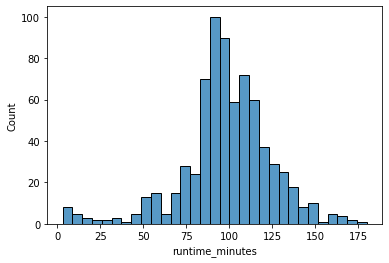

In [101]:
# visualizes distribution of movie runtime minutes
sns.histplot(top_roi_movie_basics['runtime_minutes']);

In [122]:
# getting summary statistics for top_roi_movie_basics runtimes
round(top_roi_movie_basics['runtime_minutes'].describe(), 1)

count    720.0
mean      98.4
std       26.5
min        3.0
25%       87.0
50%       99.0
75%      113.0
max      180.0
Name: runtime_minutes, dtype: float64

This output provide summary statistics for movie runtimes. The 1st Quartile (25%) and 3rd Quartile (75%) are especially important because 50% of the data lies between these two values. I will be highlighting this in the boxplot used to visualize this distribution.

/Users/chriskucewicz/anaconda3/envs/learn-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


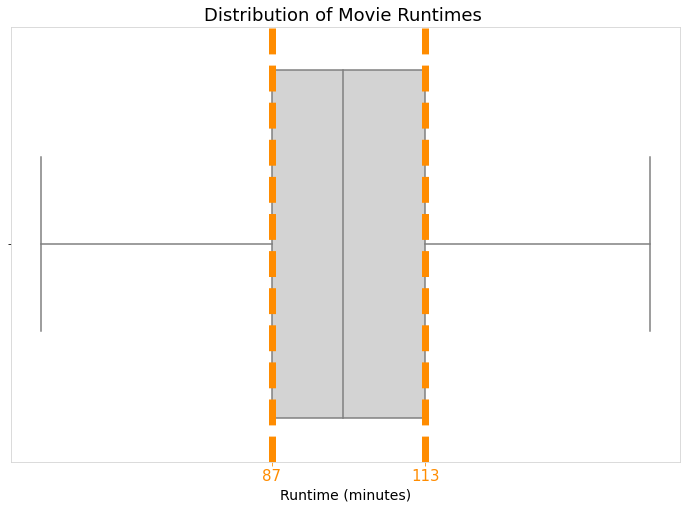

In [124]:
# boxplot for the runtime of the movies in top 25% of roi
fig, ax = plt.subplots(figsize= (12, 8))
sns.boxplot(top_roi_movie_basics['runtime_minutes'],
            showfliers = False,
            color = 'lightgrey'
           )

# creates dashed lines to emphasis Q1 and Q3 on the graph
plt.axvline(x = 87,
            color = 'darkorange',
            label = 'axvline - full height',
            linestyle = '--',
            linewidth=7.0
           )

plt.axvline(x = 113,
            color = 'darkorange',
            label = 'axvline - full height',
            linestyle = '--',
            linewidth=7.0
           )

# formatting title and axes
ax.set_title("Distribution of Movie Runtimes ",
             fontsize = 18
            )

ax.set_xlabel('Runtime (minutes)',
              fontsize = 14
             )

ax.set_xticks([87, 113])
ax.tick_params(axis='x',
               colors='darkorange',
               labelsize = 15
              )

# makes border of figure grey            
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey');

This boxplot visualizes the distribution of runtimes of movies that were in the upper quartile of ROI. This visualization draws our attention to the runtime for the middle 50% of movies. Specifically, the middle 50% of movies had **runtimes between 86 and 112 minutes**.

In [104]:
# creates a table of the median ROI for each film profession
roi_categories = top_people_budgets.groupby(['category']).median()[['roi (%)', 'production_budget (millions of $)', 'worldwide_gross (millions of $)']]

# sorts roi_categories from greatest ROI to least
roi_categories_sorted = roi_categories.sort_values('roi (%)', ascending = False) 

The above output is a table that shows the average return on investment (ROI) grouped by film profession. For example, producers had an average ROI of 2112% and actors had an average ROI of 1203%.

In [105]:
# saves the list of the top three professions by ROI %
top_3_roi_categories = roi_categories_sorted.head(3)
top_3_roi_categories

,roi (%),production_budget (millions of $),worldwide_gross (millions of $)
category,,,
Composer,724.7,18.0,115.5920
Director,685.7,23.0,172.0590
Producer,685.3,15.0,129.0865


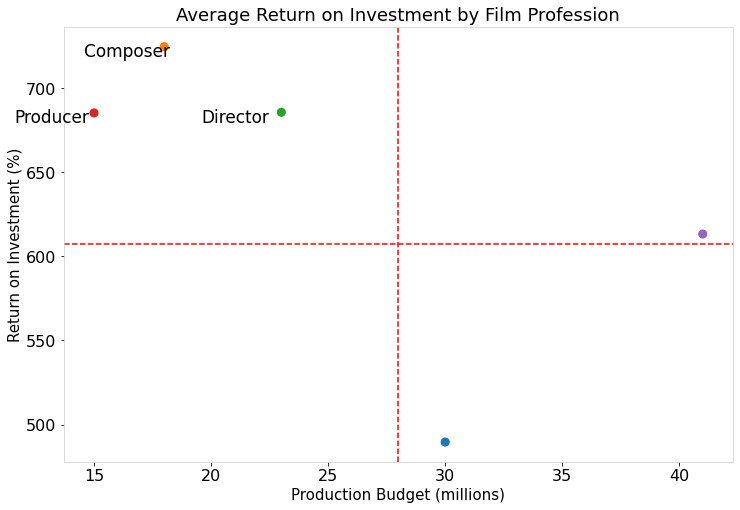

In [112]:
# calculates average ROI across all film professions which will be the horizontal threshold
roi_h_threshold = 0.5 * (roi_categories_sorted['roi (%)'].max() 
                 + roi_categories_sorted['roi (%)'].min())
    
# creates vertical threshold 
roi_v_threshold = 0.5 * (roi_categories_sorted['production_budget (millions of $)'].max() 
                 + roi_categories_sorted['production_budget (millions of $)'].min())

fig, ax = plt.subplots(figsize = (12,8))

# creates and plots scatterplot
sns.scatterplot(data = top_people_budgets.groupby(['category']).median()[['production_budget (millions of $)', 'roi (%)']],
                 x = 'production_budget (millions of $)', 
                 y = 'roi (%)',
                 s = 100,
                 hue='category',
                 )


# plots name for top 3 professions near corresponding data point
for line in range(0, top_3_roi_categories.shape[0]):
     ax.annotate(top_3_roi_categories.index[line], 
                   (top_3_roi_categories['production_budget (millions of $)'].iloc[line], 
                    top_3_roi_categories['roi (%)'].iloc[line]), 
                   fontsize=17,
                   xytext=(-80, -10),  
                   textcoords='offset points'
                )

# removes legend
ax.get_legend().remove()        

# draws line for average roi
ax.axhline(y = roi_h_threshold,
            color = 'red',
            label = 'axvline - full height',
            linestyle = '--'
          )

ax.axvline(x = roi_v_threshold,
            color = 'red',
            label = 'axvline - full height',
            linestyle = '--'
          )
# formatting title and axes
ax.set_title("Average Return on Investment by Film Profession",
             fontsize = 18
            )

ax.set_xlabel('Production Budget (millions)',
              fontsize = 15
             )

ax.set_ylabel('Return on Investment (%)',
              fontsize=15
             )

ax.tick_params(labelsize=16)
            
#ax.set_xticklabels(x.astype(int))

# makes border of figure grey            
ax.spines['left'].set_color('lightgrey')
ax.spines['right'].set_color('lightgrey')
ax.spines['top'].set_color('lightgrey')
ax.spines['bottom'].set_color('lightgrey');

In [107]:
# function that will print a list of the top 5 highest grossing people for each film profession 
def top_grossing(categories):
    for category in categories:
        
        top_category = top_people_budgets[(top_people_budgets['category'] == category) 
                                          & (top_people_budgets['genres'].str.contains('|'.join(top2_genres)
                                                                                      )
                                            )
                                         ]
        
        top_category_sum_gross = top_category.groupby(['primary_name']).sum()[['worldwide_gross (millions of $)', 'roi (%)']].sort_values('worldwide_gross (millions of $)',
                                                                                                                                          ascending = False).head(15)
        
        top_5_category = list(top_category_sum_gross.index)[:5]
        
        print(f"The top 5 highest grossing {category}s are:" + str(top_5_category))

In [108]:
top_grossing(top_3_roi_categories.index)

The top 5 highest grossing Composers are:['Danny Elfman', 'Alexandre Desplat', 'Marco Beltrami', 'Thomas Newman', 'Theodore Shapiro']
The top 5 highest grossing Directors are:['David O. Russell', 'Steven Spielberg', 'Damien Chazelle', 'Jon M. Chu', 'M. Night Shyamalan']
The top 5 highest grossing Producers are:['Simon Kinberg', 'Michael De Luca', 'Dana Brunetti', 'Wyck Godfrey', 'Peter Chernin']


In [109]:
def plot_top_grossing(categories): #bar_width):
    #top_grossing(categories)
        fig, ax = plt.subplots(nrows = 1, ncols = len(categories), figsize = (18,8))

        for index, category in enumerate(categories):

            top_category = top_people_budgets[(top_people_budgets['category'] == category) 
                                              & (top_people_budgets['genres'].str.contains('|'.join(top2_genres)))]

            top_category_sum_gross = top_category.groupby(['primary_name']).sum()[['worldwide_gross (millions of $)', 'roi (%)']].sort_values('worldwide_gross (millions of $)',
                                                                                                                                              ascending = False).head(10)

            top_5_category = list(top_category_sum_gross.index)[:5]

            top_sum_category_colors = ['orange' if x in top_5_category else 'lightgrey' for x in top_category_sum_gross.index]
            top_sum_categories_tick_colors = ['black' if x in top_5_category else 'grey' for x in top_category_sum_gross.index]

            sns.barplot(
                y = top_category_sum_gross.index, 
                x = top_category_sum_gross['worldwide_gross (millions of $)'], 
                palette = top_sum_category_colors,
                ax = ax[index]
            )
            
            ax[index].set_title(f"Total Gross Revenue Across Movies",
                                fontsize = 18
                               )
            
            ax[index].set_xlabel('Total Gross $ (millions)',
                                 fontsize = 16
                                )
            
            ax[index].set_ylabel(f'{category}',
                                 fontsize=14
                                )
            
            ax[index].tick_params(labelsize=16)
            
            ax[index].set_yticklabels(labels = top_category_sum_gross.index)
            
            for ticklabel, tickcolor in zip(ax[index].get_yticklabels(), top_sum_categories_tick_colors):
                ticklabel.set_color(tickcolor)
                
            ax[index].spines['left'].set_color('lightgrey')
            ax[index].spines['right'].set_color('lightgrey')
            ax[index].spines['top'].set_color('lightgrey')
            ax[index].spines['bottom'].set_color('lightgrey');

        fig.tight_layout(pad=3.0)
        plt.show()

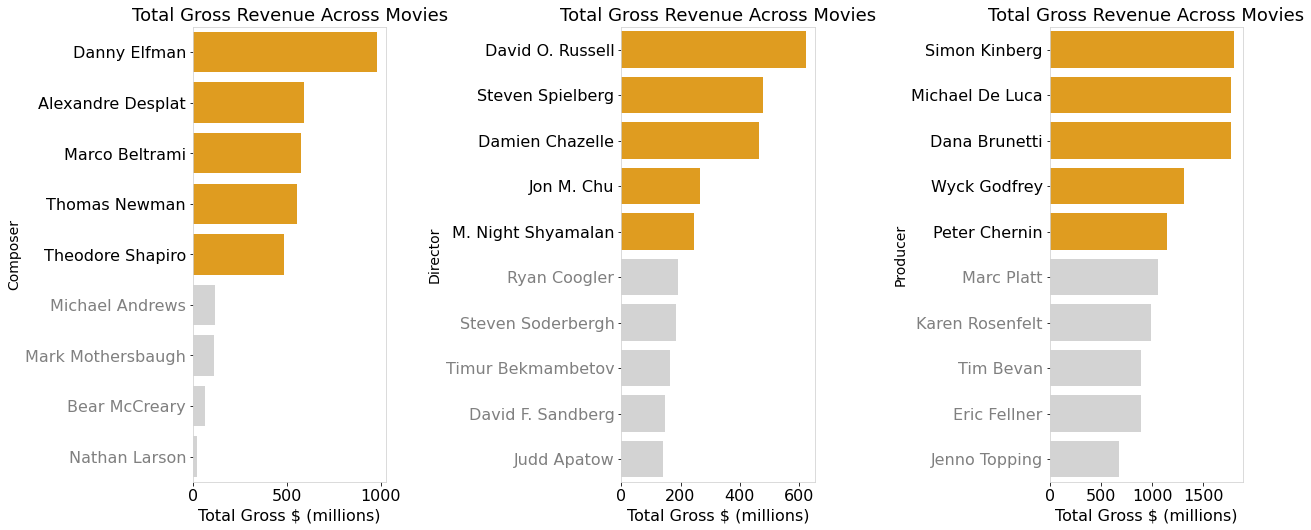

In [110]:
plot_top_grossing(top_3_roi_categories.index)

## 5. <a name ="Conclusions"></a> Conclusions
 
### Limitations
While these datasets and tables offered a variety of data, there was a limited amount of data on the budgets for movies. This resulted in a large discrepancy between the number of entries in the budgets table (~5000) and number of entries tables within the IMDB database, with one table having over 1 million entries. Because of this, the analysis was limited in the amount of movies available to analyze due to a shortage of movie budget data. A more comprehensive dataset including budget data on a wider variety of movies would provide a more complete analysis with more informed recommendations about the features that impact a movie's return on investment. 

### Recommendations

This analysis leads to three recommendations for movie creation:

1. Focus on creating movies within the ***drama or comedy genres***.

$\;\;\;\;\;\;$ - Over **one-third** of the movies with the highest ROI were classified as dramas and/or comedies. 

2. Create movies with ***runtimes between 87 and 114 minutes***.

$\;\;\;\;\;\;$ - Half of all movies with the highest ROI had runtimes between 87 and 114 minutes.

3. Focus on hiring ***high-quality producers, writers, and directors***, as these three professions had the highest ROI out of all film professions.

$\;\;\;\;\;\;$ - List of recommended movie producers, comprising the top five highest-grossing producers: Simon Kinberg, Dana Brunetti, Michael De Luca, Wyck Godfrey, Peter Chernin

$\;\;\;\;\;\;$ - List of recommended movie writers, comprising the top five highest-grossing writers: E.L. James, Anthony McCarten, Linda Woolverton, Eric Heisserer, Robert Mark Kamen

$\;\;\;\;\;\;$ - List of recommended movie directors, comprising the top five highest-grossing directors: David O. Russell, Steven Spielberg, Damien Chazelle, Lasse Hallström, Jon M. Chu


### Next Steps

With these recommendations in mind, I am interested the following next steps:
- gathering more budget data on a larger amount of movies
- performing regression analysis to determine which factors are most strongly correlated with a movie's return on investment

### 6. <a name ="Resources"></a> Resources

- got error when trying to read in reviews.tsv dataset: "UnicodeDecodeError: 'utf8' codec can't decode byte 0xa5 in position 0: invalid start byte". This resource helped: https://stackoverflow.com/questions/22216076/unicodedecodeerror-utf8-codec-cant-decode-byte-0xa5-in-position-0-invalid-s

- Had trouble reading zipped data with pandas. This helped me with reading in the csv and tsv data: https://stackoverflow.com/questions/18885175/read-a-zipped-file-as-a-pandas-dataframe

- for joining datasets: https://stackoverflow.com/questions/53645882/pandas-merging-101

- the movie_info dataset had the word 'minutes' in each entry for runtime. Just wanted the numbers. this was helpful:
https://saturncloud.io/blog/how-to-remove-characters-from-a-pandas-column-a-data-scientists-guide/

- merging on more than one condition: https://stackoverflow.com/questions/53549492/joining-two-pandas-dataframes-based-on-multiple-conditions

- dropping nulls in certain columns: https://saturncloud.io/blog/how-to-delete-rows-with-null-values-in-a-specific-column-in-pandas-dataframe/#:~:text=Deleting%20rows%20with%20null%20values%20in%20a%20specific%20column%20can,values%20in%20the%20specified%20column.&text=df%20is%20the%20Pandas%20DataFrame%20that%20you%20want%20to%20modify.

- for subsetting dataframe to only show entries with value count more than one https://stackoverflow.com/questions/48628417/how-to-select-rows-in-pandas-dataframe-where-value-appears-more-than-once

- Finding rows with matching entries: https://stackoverflow.com/questions/22485375/efficiently-select-rows-that-match-one-of-several-values-in-pandas-dataframe

For trying to split the genres column into new columns: 
- https://saturncloud.io/blog/how-to-split-one-column-into-multiple-columns-in-pandas-dataframe/#:~:text=Using%20the%20pd.&text=Series.-,str.,list%20as%20a%20new%20column.

- https://www.reddit.com/r/learnpython/comments/krasnw/how_to_put_my_genres_in_their_own_df_with_their/

For multi-indexing / using a pivot table to group people by the movies they've been in:
- https://www.datacamp.com/tutorial/pandas-multi-index
- https://stackoverflow.com/questions/35414625/pandas-how-to-run-a-pivot-with-a-multi-index
- https://stackoverflow.com/questions/61623982/python-pandas-grouping-columns-without-aggregating

https://www.reddit.com/r/SQL/comments/15z6ee7/cleaning_before_joining/

return rows in the top x% of a given column: 
- https://stackoverflow.com/questions/52876391/pandas-based-on-top-x-value-of-each-column-mark-as-new-number

For creating a dictionary that lists the number of rows for each table: 
- https://stackoverflow.com/questions/71432838/for-loop-to-create-a-dataframe-using-pandas-read-sql-in-python

Use a for loop to create multiple bar plots: 
- https://stackoverflow.com/questions/43962735/creating-barplots-using-for-loop-using-pandas-matplotlib

filer based on value counts:
- https://stackoverflow.com/questions/49735683/python-removing-rows-on-count-condition

for searching list within df col:
- https://stackoverflow.com/questions/50355825/pandas-using-isin-to-return-if-column-contains-any-values-in-a-list-rather-th

For more information about role of movie director vs producer: 
- https://www.linkedin.com/pulse/producer-vs-director-who-has-power-adam-snook-sczoc/

For labeling points on scatterplot: 
- https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn

For adjusting the tick marking colors: 
- https://stackoverflow.com/questions/39409530/every-tick-label-in-different-color